The problem we have is a gridding problem, with a **large dataset**. There is two approaches we can take:
- If we can load the data in whole to memory we are of course way faster and can further optimize and distribute the processing. 
- If we are not able to load the data in whole to memory, then we have to do it in chunks.

Here we will analyze both approaches, and test our code across multi CPU/GPU nodes and compare the performance.

The organization of the notebook and the material is as follow:

- First we will try to optimize and vectorize the code, test it for both loading the data in whole and in chunks.
- Then we will distribute the processing, first in python using multiprocessing and mpi4py and then we will rewrite the gridding in C and use the gridding library in python.

**Note:** The experiments in this notebook are done in AMD EPYC 7H12 CPU node, with 2 sockets, 64 cores per socket, and 1 thread per core, totalling 128 cpu cores.

In [1]:
import time
from functools import wraps

# we define for now a simple profiling decorator
def profile(func):
    tot_time = 0
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        return_value = func(*args, **kwargs)
        end = time.perf_counter()
        spent_time = end - start
        print(f"func: {func.__name__}")
        print(f"time: {spent_time:10.8f}s")
        print("-"*21)
        return return_value
    return wrapper

In [2]:
import numpy as np
import xarray as xr
import zarr as zr
import matplotlib.pyplot as plt

In [3]:
# speed of light
c = 299792458
# size of image in pixels
image_size = 2048 
# size of image on sky, directional cosines
theta = 0.0125
# dataset path
dataset_path = "./example_simulation.zarr"
# cutoff time step, used for testing, 512 is the max
cutoff_timestep = 512

In [4]:
@profile
def open_dataset(dataset_path):
    dataset = xr.open_zarr(dataset_path)
    return dataset
    
dataset = open_dataset(dataset_path)
# select `cutoff_timestep` slices in time, for testing
dataset = dataset.isel(time=slice(0, cutoff_timestep))
num_timesteps = len(dataset.time)
num_baselines = len(dataset.baseline_id)
dataset

func: open_dataset
time: 0.02527677s
---------------------


<xarray.Dataset> Size: 740MB
Dimensions:               (time: 512, baseline_id: 351, uvw_label: 3,
                           frequency: 256, baseline_antenna1_id: 351,
                           baseline_antenna2_id: 351, polarization: 1)
Coordinates:
  * baseline_antenna1_id  (baseline_antenna1_id) int32 1kB 0 0 0 0 ... 24 24 25
  * baseline_antenna2_id  (baseline_antenna2_id) int32 1kB 1 2 3 4 ... 25 26 26
  * baseline_id           (baseline_id) int32 1kB 0 1 2 3 4 ... 347 348 349 350
  * frequency             (frequency) float64 2kB 2.998e+08 ... 3.091e+08
  * polarization          (polarization) <U1 4B 'I'
  * time                  (time) float64 4kB 1.715e+09 1.715e+09 ... 1.715e+09
  * uvw_label             (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    UVW                   (time, baseline_id, uvw_label) float64 4MB ...
    VISIBILITY            (time, baseline_id, frequency) complex128 736MB ...
Attributes:
    creation_date:  2024-05-09T07:00:00+00:00.000
    intent:         Example Simulation
    version:        0.0.1

In [5]:
uvwt = dataset.UVW
vist = dataset.VISIBILITY
freq = dataset.frequency.data

In [6]:
print(f"dataset.UVW.shape:        {dataset.UVW.shape}")
print(f"dataset.VISIBILITY.shape: {dataset.VISIBILITY.shape}")
print(f"dataset.frequency.shape:  {dataset.frequency.shape}")
print(f"number of timesteps: {num_timesteps}")
print(f"number of baselines: {num_baselines}")

dataset.UVW.shape:        (512, 351, 3)
dataset.VISIBILITY.shape: (512, 351, 256)
dataset.frequency.shape:  (256,)
number of timesteps: 512
number of baselines: 351


In [7]:
def calculate_indices(uvw_0, uvw_1, f):
    iu = round(theta * uvw_0 * f / c)
    iv = round(theta * uvw_1 * f / c)
    iu_idx = iu + image_size//2
    iv_idx = iv + image_size//2
    return iu_idx, iv_idx

This is the original version of the code (v0), This has one good thing in it, that it loads the data, per time iteration, whenever it's needed, through xarray API. Other than that, it is extremely slow, as it is expected when we nest 3 loops in pure python:

In [8]:
@profile
def gridding_v0(uvwt, vist, frq):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    
    for (uvwb, visb) in zip(uvwt, vist):
        for(uvw, vis) in zip(uvwb.compute().data, visb.compute().data):
            for(fq, vi) in zip(frq, vis):
                iu_idx, iv_idx = calculate_indices(uvw[0], uvw[1], fq)
                grid[iu_idx, iv_idx] += vi
                
    return grid

In [7]:
@profile
def fourier_transform(grid):
    image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(grid))).real
    return image

In [8]:
@profile
def plot_image(image):
    plt.figure(figsize=(8,8)) 
    plt.imshow(image)
    plt.colorbar(shrink=0.8)

func: gridding_v0
time: 247.05855824s
---------------------
func: fourier_transform
time: 0.42531535s
---------------------
func: plot_image
time: 0.14888715s
---------------------


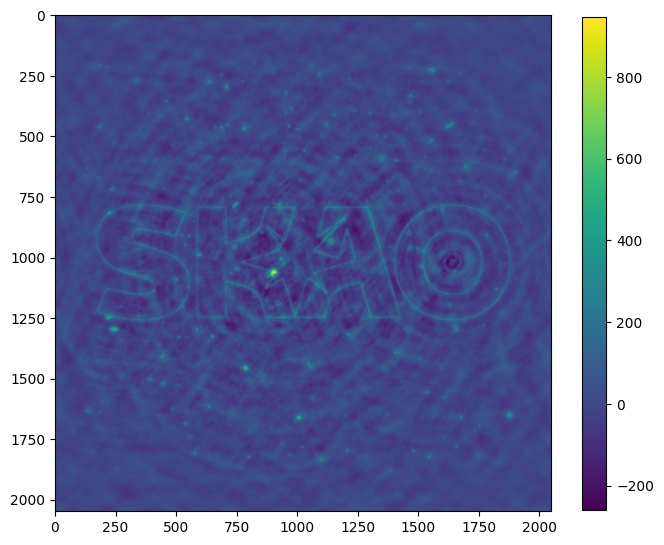

In [11]:
grid = gridding_v0(uvwt, vist, freq)
image = fourier_transform(grid)
plot_image(image)

As evident from the profiling above, it's not at all feasable the gridding snippet above, it runs only on one core of the 128 available. We can try one simple trick to **Just In Compile (JIT)** the computationally expensive parts of the code, here we do it for the index calculation part for now:

In [12]:
from numba import njit

@njit
def calculate_indices_jit(uvw_0, uvw_1, f):
    iu = round(theta * uvw_0 * f / c)
    iv = round(theta * uvw_1 * f / c)
    iu_idx = iu + image_size//2
    iv_idx = iv + image_size//2
    return iu_idx, iv_idx

@profile
def gridding_v0_jit_index_calc(uvwt, vist, frq):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    
    for (uvwb, visb) in zip(uvwt, vist):
        for(uvw, vis) in zip(uvwb.compute().data, visb.compute().data):
            for(fq, vi) in zip(frq, vis):
                iu_idx, iv_idx = calculate_indices_jit(uvw[0], uvw[1], fq)
                grid[iu_idx, iv_idx] += vi
                
    return grid

func: gridding_v0_jit_index_calc
time: 101.95593394s
---------------------
func: fourier_transform
time: 0.41937157s
---------------------
func: plot_image
time: 0.03649272s
---------------------


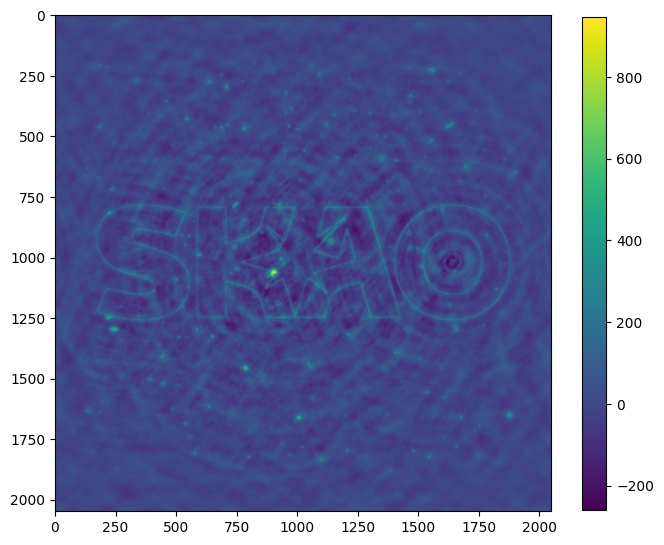

In [13]:
grid = gridding_v0_jit_index_calc(uvwt, vist, freq)
image = fourier_transform(grid)
plot_image(image)

This imporoves the code performance, but if we could load the data in whole (i.e. eager) to memory but not via the dask API (i.e. lazy), we could convert the dataset across the needed dimensions to numpy array and JIT the whole gridding function:

In [9]:
uvwt_np = dataset.UVW.compute().to_numpy()
vist_np = dataset.VISIBILITY.compute().to_numpy()
freq_np = dataset.frequency.compute().to_numpy()

In [7]:
from numba import njit

@njit
def gridding_v0_jit(uvwt_np, vist_np, frq_np):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    
    for (uvwb, visb) in zip(uvwt_np, vist_np):
        for(uvw, vis) in zip(uvwb, visb):
            for(fq, vi) in zip(frq_np, vis):
                iu = round(theta * uvw[0] * fq / c)
                iv = round(theta * uvw[1] * fq / c)
                iu_idx = iu + image_size//2
                iv_idx = iv + image_size//2
                grid[iu_idx, iv_idx] += vi
                
    return grid

func: gridding_v0_jit
time: 0.23827566s
---------------------
func: fourier_transform
time: 0.39088301s
---------------------
func: plot_image
time: 0.03518638s
---------------------


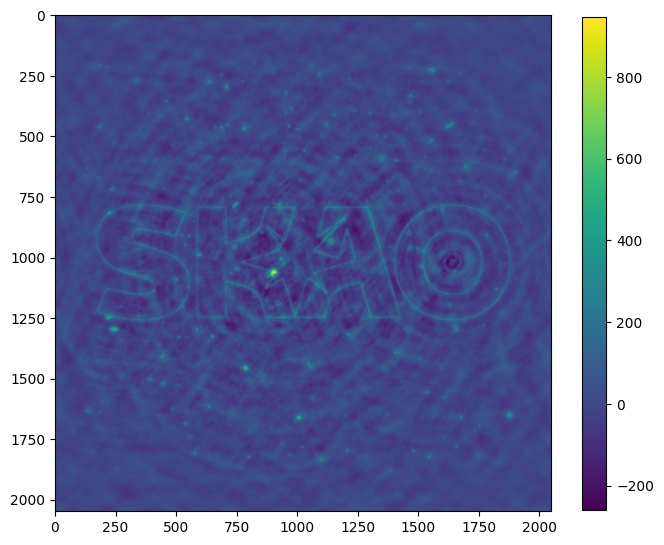

In [12]:
t_start = time.perf_counter()
grid = gridding_v0_jit(uvwt_np, vist_np, freq_np)
tot_time = time.perf_counter() - t_start

print(f"func: gridding_v0_jit")
print(f"time: {tot_time:10.8f}s")
print("-"*21)

image = fourier_transform(grid)
plot_image(image)

As is evident from the above, that improves the code performance by orders of magnitude, as we will see later our goal really should be to achieve that level of performance but also in a more controlable and distributed mannter.

In the section below we get rid of the nested loops and **vectorize** the first the gridding along timesteps, try jitting that, and then we vectorize the whole gridding function, and compare the results, one advantage of vectorizing along only the timestep is that we can load the data for each time step as needed as opposed to loading the whole dataset at once and vectorizing the whole function:

In [7]:
def gridding_single_timestep_v1(grid, uvwb, visb, freq):
    uvw0 = uvwb[:,0] 
    uvw1 = uvwb[:,1]
    uvw0 = np.expand_dims(uvw0, axis=0) # (1, 351)
    uvw1 = np.expand_dims(uvw1, axis=0) # (1, 351)
    freq = np.expand_dims(freq, axis=1) # (256, 1)
    visb = np.swapaxes(visb, 0, -1)     # (256, 351)

    iu = np.round(theta * uvw0 * freq / c).astype(np.int32)
    iv = np.round(theta * uvw1 * freq / c).astype(np.int32)
    iu_idx = iu + image_size // 2
    iv_idx = iv + image_size // 2

    np.add.at(grid, (iu_idx, iv_idx), visb)
    
    return grid

@profile
def gridding_v1(uvwt, vist, frq):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    for t in range(num_timesteps):
        grid += gridding_single_timestep_v1(grid, uvwt[t].compute().data, vist[t].compute().data, frq)
    return grid

func: fourier_transform
time: 0.39263902s
---------------------
func: plot_image
time: 0.04296099s
---------------------


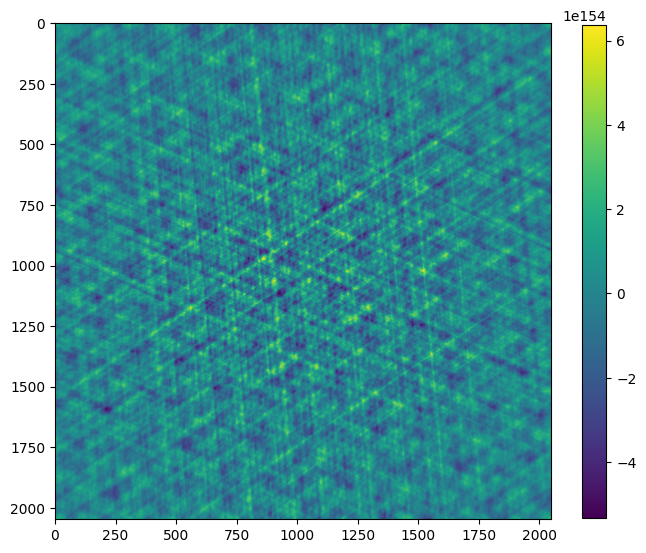

In [11]:
grid = gridding_v1(uvwt, vist, freq)
image = fourier_transform(grid)
plot_image(image)

In [13]:
from numba import njit

@njit
def gridding_single_timestep_v1_jit(grid, uvwb, visb, freq):
    uvw0 = uvwb[:,0] 
    uvw1 = uvwb[:,1]
    uvw0 = np.expand_dims(uvw0, axis=0) # (1, 351)
    uvw1 = np.expand_dims(uvw1, axis=0) # (1, 351)
    freq = np.expand_dims(freq, axis=1) # (256, 1)
    visb = np.swapaxes(visb, 0, -1)     # (256, 351)

    iu = np.round(theta * uvw0 * freq / c).astype(np.int32)
    iv = np.round(theta * uvw1 * freq / c).astype(np.int32)
    iu_idx = iu + image_size // 2
    iv_idx = iv + image_size // 2
    
    for i in range(351):
        for j in range(256):
            grid[iu_idx[i, j], iv_idx[i, j]] += visb[i, j]
     
    return grid

@profile
def gridding_v1_jit(uvwt, vist, freq):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    for t in range(num_timesteps):
        grid_timestep = gridding_single_timestep_v1_jit(grid, uvwt[t].compute().data, vist[t].compute().data, freq)
        grid += grid_timestep
    return grid

In [ ]:
grid = gridding_v1_jit(uvwt, vist, freq)
image = fourier_transform(grid)
plot_image(image)

This is the the **completely vectorized** version of the gridding and it's fast, because it's using the underlying optimized numpy vectorized operations, but of course for this we loaded the whole data into memory:

In [10]:
@profile
def gridding_v2(uvwt, vist, freq):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    uvw0 = uvwt[:,:,0]
    uvw1 = uvwt[:,:,1]

    uvw0 = np.expand_dims(uvw0, axis=1) # (512, 351, 1)
    uvw1 = np.expand_dims(uvw1, axis=1) # (512, 351, 1)
    freq = np.expand_dims(freq, axis=1) # (1, 256)

    iu = np.round(theta * uvw0 * freq / c).astype(int)
    iv = np.round(theta * uvw1 * freq / c).astype(int)
    iu_idx = iu + image_size // 2
    iv_idx = iv + image_size // 2

    vist = np.swapaxes(vist, 1, -1) # (512, 256, 351)
    np.add.at(grid, (iu_idx, iv_idx), vist)
    
    return grid

func: gridding_v2
time: 1.33170569s
---------------------
func: fourier_transform
time: 0.39856156s
---------------------
func: plot_image
time: 0.04257603s
---------------------


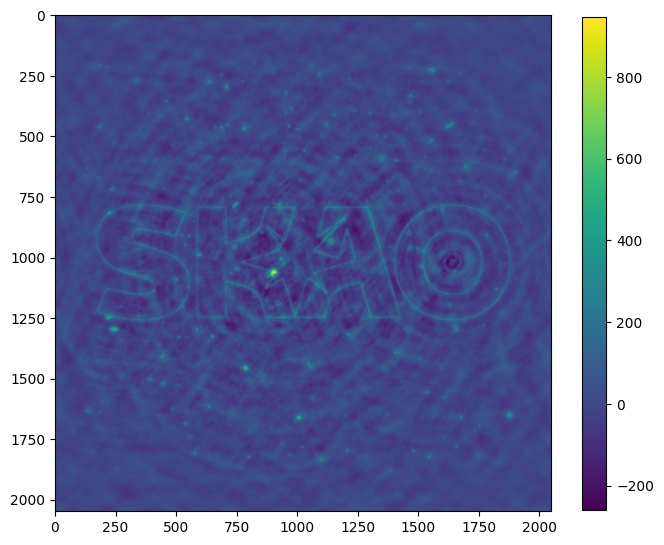

In [11]:
grid = gridding_v2(uvwt_np, vist_np, freq_np)
image = fourier_transform(grid)
plot_image(image)

Here we put the parallel processing of the gridding with **Threads**, one advantage of this is that we can load the data in chunks into memory and we don;t needed the fully loaded version of it, we load the data in chunks process it with certain number of threads and we go to the next one:

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def sum_vis(grid, iu, iv, vis):
    np.add.at(grid, (iu, iv), vis)
    return grid

@profile
def gridding_threads(uvwt, vist, freq, n_workers=4):
    grid = np.zeros((image_size, image_size), dtype=np.complex128)
    uvw0 = uvwt[:,:,0]
    uvw1 = uvwt[:,:,1]
 
    iu = (theta * uvw0 * freq / c).round().astype(int)  # (512, 351, 256)
    iv = (theta * uvw1 * freq / c).round().astype(int)  # (512, 351, 256)
    iu_idx = iu + image_size // 2
    iv_idx = iv + image_size // 2

    # split data into chunks to be processed by a thread
    def chunk_data(data, n_chunks):
        chunk_size = data.shape[0] // n_chunks
        return [data[i*chunk_size:(i+1)*chunk_size] for i in range(n_chunks)]

    iu_chunks  = chunk_data(iu_idx, n_workers)
    iv_chunks  = chunk_data(iv_idx, n_workers)
    vis_chunks = chunk_data(vist, n_workers)

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = []
        for iu_chunk, iv_chunk, vis_chunk in zip(iu_chunks, iv_chunks, vis_chunks):
            futures.append(executor.submit(sum_vis, grid.copy(), \
                                           iu_chunk.compute().data, \
                                           iv_chunk.compute().data, \
                                           vis_chunk.compute().data))

        for future in as_completed(futures):
            grid += future.result()

    return grid

func: gridding_threads
time: 6.62689134s
---------------------
func: fourier_transform
time: 0.39033506s
---------------------
func: plot_image
time: 0.03211795s
---------------------


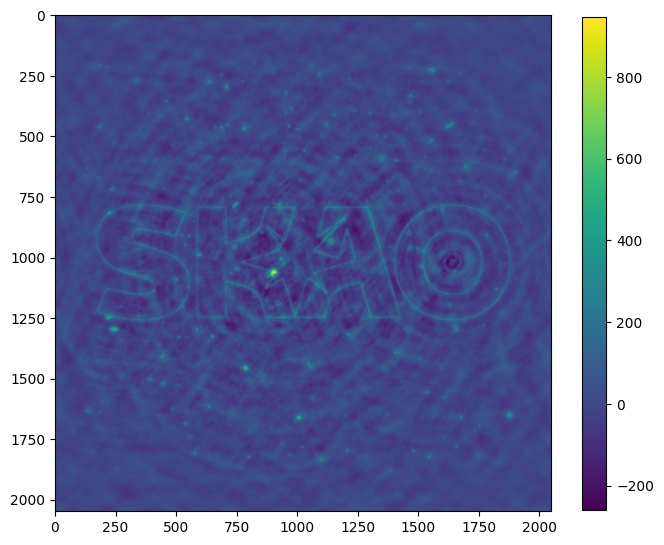

In [16]:
grid = gridding_threads(uvwt, vist, dataset.frequency, 32)
image = fourier_transform(grid)
plot_image(image)